# **Homework 4 - Getting to know your customers**
___

Import packages

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib.pyplot import figure
from collections import defaultdict
import matplotlib.pyplot as plt 
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle

Clean the dataset

In [ ]:
data = pd.read_csv('bank_transactions.csv')

In [ ]:
# We use this function to convert TransactionTime in time
def zeros(x):
    l = len(x)
    if l != 6:
        x = '0' * (6-l) + x
    return x

In [ ]:
# We have about 7000 rows with missing values so we can just drop them
data.dropna(inplace=True)

# Convert in datetime this two columns
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)
data.TransactionDate = pd.to_datetime(data.TransactionDate)

# For TransactionTime we need to split the int in hours, minutes and seconds and convert it in datatime
data.TransactionTime = list(map(str,data.TransactionTime))
data.TransactionTime = list(map(zeros,data.TransactionTime))
data.TransactionTime = pd.to_datetime(data.TransactionTime.apply(lambda x: f'{x[:2]}:{x[2:4]}:{x[4:]}'), format='%H:%M:%S').dt.time

# Adjusting CustomerDOB bringing all the data after 2000 in the previous century and delating all the ones of the 1800
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

# Converting TransactionAmount in integer
data['TransactionAmount (INR)'] = data['TransactionAmount (INR)'].astype(int)

# Saving the new dataset in pickle format
data.to_pickle('clear_dataset.pkl')

___
## **1. Finding Similar Costumers**

### 1.1 Set up the data

In [2]:
bank_data = pd.read_pickle('clear_dataset.pkl')
bank_data = bank_data.reset_index(drop=True)

# Cleaning dataset taking unique people (removing multiple transaction from same person).
bank_data.insert(0, 'new_ID', (bank_data.CustomerID + list(map(str, pd.to_datetime(bank_data.CustomerDOB).dt.date))))

bank_data.head()

,new_ID,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,C58410531994-10-01,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25
1,C21427631957-04-04,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999
2,C44170681996-11-26,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459
3,C53423801973-09-14,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060
4,C90312341988-03-24,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762


In [3]:
# Choosing selected column to find similarity between customer for Locality Sensitive Hashing (LSH).
hash_bank_data = bank_data[['new_ID', 'CustGender', 'CustomerDOB', 'CustLocation', 'CustAccountBalance', 'TransactionAmount (INR)']]
hash_bank_data = hash_bank_data.rename({'CustomerDOB': 'CustomerMOB'}, axis=1)
hash_bank_data.insert(3, 'CustomerYOB', list(map(str, hash_bank_data.CustomerMOB.dt.year)))          # Insert Year Of Birthday.
hash_bank_data.CustomerMOB = hash_bank_data.CustomerMOB.dt.month_name()                              # Insert Month Of Birthday.
hash_bank_data.CustGender = ['Male' if i =='M' else 'Female' for i in hash_bank_data.CustGender]     # Convert gender to Male and Female.
hash_bank_data.CustLocation = hash_bank_data.CustLocation.apply(lambda x: ''.join(x.split()))        # Convert in one word the locations.

# Convert CustomerYOB in classes of age (min_age, 35, 70, max_age) as (young, middle_age, old)
ages = 2016 - np.array(list(map(int, hash_bank_data.CustomerYOB)))
bins = [min(ages), 35, 70, max(ages)]
labels = ['young', 'middle_age', 'old']
hash_bank_data.CustomerYOB = list(map(str, pd.cut(ages, bins, labels=labels, ordered=False)))

# Convert CustAccountBalance in ranges (quantiles .2, .4, .6, .8).
bins = list(map(int, hash_bank_data.CustAccountBalance.quantile([0, .2, .4, .6, .8, 1])))
hash_bank_data.CustAccountBalance = list(map(str, pd.cut(hash_bank_data.CustAccountBalance, bins,
     labels=[f'balance_range_{i}' for i in range(1, len(bins))], ordered=False)))

# Convert TransactionAmount (INR) in ranges (quartiles).
bins = list(map(int, hash_bank_data['TransactionAmount (INR)'].quantile([0, .25, .5, .75, 1])))
hash_bank_data['TransactionAmount (INR)'] = list(map(str, pd.cut(hash_bank_data['TransactionAmount (INR)'], bins,
     labels=[f'transaction_quartile_{i}' for i in range(1, len(bins))], ordered=False)))

# We now just want to identify unique clients.
# Removing those that have done more than one transaction (same person not Customer).
hash_bank_data = hash_bank_data.drop_duplicates(subset = ['new_ID'], keep = 'last').reset_index(drop = True)

# Saving dataset for apply LSH.
hash_bank_data.to_pickle('LSH_bank_transaction.pkl')

hash_bank_data.head()

,new_ID,CustGender,CustomerMOB,CustomerYOB,CustLocation,CustAccountBalance,TransactionAmount (INR)
0,C58410531994-10-01,Female,October,young,JAMSHEDPUR,balance_range_3,transaction_quartile_1
1,C21427631957-04-04,Male,April,middle_age,JHAJJAR,balance_range_1,transaction_quartile_4
2,C44170681996-11-26,Female,November,young,MUMBAI,balance_range_3,transaction_quartile_3
3,C53423801973-09-14,Female,September,middle_age,MUMBAI,balance_range_5,transaction_quartile_4
4,C90312341988-03-24,Female,March,young,NAVIMUMBAI,balance_range_2,transaction_quartile_4


As features to create shingles for minhash we consider this 6 variables above: the gender converted in male and female, the month of birth, year of birth, location transaction, account balance converted in 5 intervals divided by quantiles [.2, .4, .6, .8] and the transaction divided in four group by the three quartile. The set of the words inside this new dataset will be the rows of our initial binary sparse matrix that we named **shingle_mat**.

### 1.2 Fingerprint hashing

In [4]:
LSH_data = pd.read_pickle('LSH_bank_transaction.pkl')

LSH_final = LSH_data[['CustGender', 'CustomerMOB', 'CustomerYOB', 'CustLocation', 'CustAccountBalance', 'TransactionAmount (INR)']]
ids = list(LSH_data.new_ID)
rows = LSH_final.apply(lambda x: ' '.join(x.values), axis=1)

vec = CountVectorizer()                                                    
shingle_mat = vec.fit_transform(rows).tocsr().transpose()

In [5]:
# Return the signature matrix given shingles matrix and a number of permutations.
def signature_matrix(shingle_mat, n_perm):
    sign_mat = np.empty([n_perm, shingle_mat.shape[1]], dtype='int')

    for i in tqdm(range(n_perm)):
        # Set a seed to have same permutations in query matrix.
        np.random.seed(10+i)    

        perm = np.random.permutation(range(0, shingle_mat.shape[0]))
        perm_mat = shingle_mat[perm]
        sign_mat[i] = perm_mat.argmax(axis=0)
    
    return sign_mat


# Return a dictionary with buckets that contain similar objects.
def buckets(mat):
    dic = defaultdict(list)

    for i,item in enumerate(mat):
        dic[str(item)].append(i)
        
    return dic


# Return all the buckets for all the bands.
def LSH_function(sign_mat, b):
    all_buckets = []
    i = 0
    r = int(sign_mat.shape[0] / b)

    for _ in tqdm(range(b)):
        band = sign_mat[i:(i+r)]
        i += r
        all_buckets.append(buckets(band.T))

    return all_buckets

From the **shingles_mat** we create 4 different signature matrixes (**sign_mat**) with 100 permutations each and apply the *LSH* with four different bands *[5, 10, 20, 25]* that implies for each band these numbers of rows *[20, 10, 5, 4]* $ (\frac{perm}{bands}=rows) $. The next step is compare the results that we get for each combination of bands and rows and choose the best for our analysis.

In [ ]:
# Here we create the signature matrix and try LSH_function for different values of the band. 

# Create the signature matrix and save it.
sign_mat = signature_matrix(shingle_mat, n_perm=100)
np.save('signature_matrix.npy', sign_mat)
sign_mat = np.load('signature_matrix.npy')

# Computing the LSH function on different values of band: [5, 10, 20, 25].
all_buckets = LSH_function(sign_mat, b=5)
pickle.dump(all_buckets, open('buckets_band5.pkl', 'wb'))
all_buckets = LSH_function(sign_mat, b=10)
pickle.dump(all_buckets, open('buckets_band10.pkl', 'wb'))
all_buckets = LSH_function(sign_mat, b=20)
pickle.dump(all_buckets, open('buckets_band20.pkl', 'wb'))
all_buckets = LSH_function(sign_mat, b=25)
pickle.dump(all_buckets, open('buckets_band25.pkl', 'wb'))

To find the similarity between two customers we use the **Jaccard Similarity** defined as $$ J(A,B) = \frac{|A \cap B|}{|A \cup B|} $$
The values that this measure can assume, given that we are working with 6 features, are the following:

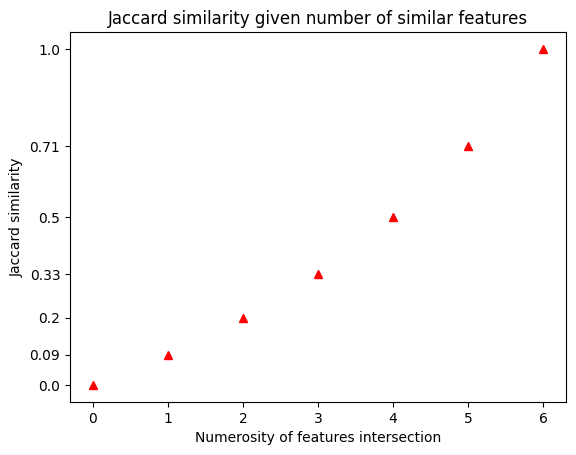

In [6]:
tot = 6
num = [0, 1, 2, 3, 4, 5, 6]
jaccard = [round(el/(tot + (tot-i)), 2) for i,el in enumerate(num)]

plt.plot(num, jaccard, 'r^')
plt.title('Jaccard similarity given number of similar features')
plt.xlabel('Numerosity of features intersection')
plt.ylabel('Jaccard similarity')
plt.yticks(jaccard, jaccard)
plt.show()

Now we know that the probability that a pair of customer being identified as similar given a similarity score is 
$$
    p = 1- (1-s^r)^b
$$
where **s** is the true similarity (*Jaccard Similarity*), **b** is the number of bands and **r** the number of rows inside each band.
In our case we have the following results taken ``100`` different *permutations*:

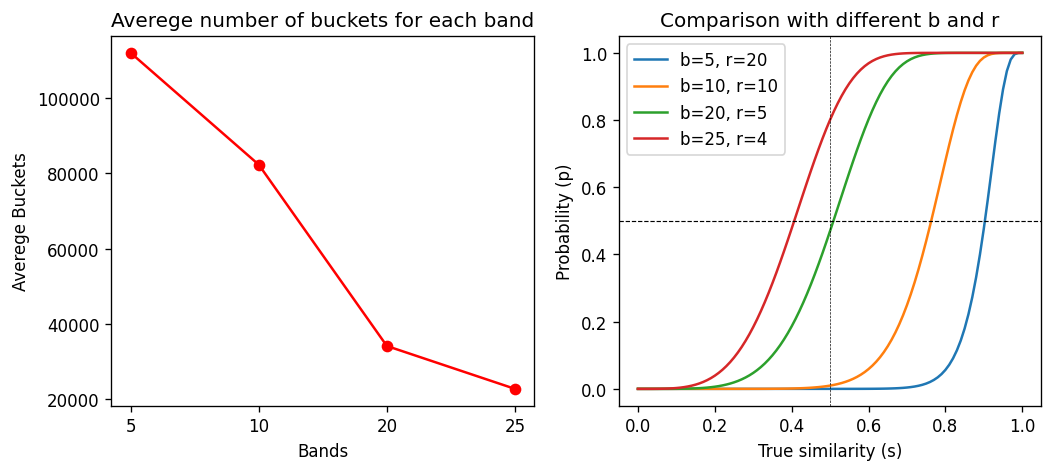

In [7]:
figure(figsize=(10, 4), dpi=120)

# First graph: Averege number of buckets for each band.
bands = [5, 10, 20, 25]
means = {}
for el in bands:
    all_buckets = pickle.load(open(f'buckets_band{el}.pkl', 'rb'))
    n_bucks = [len(all_buckets[i]) for i in range(el)]
    means[el] = np.mean(n_bucks)

plt.subplot(1, 2 ,1)
plt.plot(range(len(bands)), means.values(), 'o-r')
plt.title('Averege number of buckets for each band')
plt.xlabel('Bands')
plt.ylabel('Averege Buckets')
plt.xticks(range(len(bands)), bands)


# Second graph: Comparison with different b and r.
def prob_sim(l, b, r):
    return [1-(1-(i)**r)**b for i in l]

seq = np.arange(0,1.01,.01)
br = [(5, 20), (10, 10), (20, 5), (25, 4)]

plt.subplot(1, 2 ,2)
for el in br:
    plt.plot(seq, prob_sim(seq, el[0], el[1]), label=f'b={el[0]}, r={el[1]}')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=.7)
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=.4)
plt.title('Comparison with different b and r')
plt.xlabel('True similarity (s)')
plt.ylabel('Probability (p)')
plt.legend()
plt.show()

These graphs tell us that if we use a low number of bands, and therefore an high value for the number of rows, we get an high probability to find a similarity between two units only if their true similarity is really high (**blue curve**); in fact as we can see from the first chart when we pick a low number of bands we have a lot of different buckets: is less likely that two units end up insiede the same bucket if they have a low true similarity. Otherwise we have opposite results considering an high number of bands and a low number of rows (**red curve**: the probability to have two units in the same bucket is 50% if their true similarity score is around 0.4).

<u>Our decision</u> should consider the similarity that we want to have among the units of our data: we use 6 variables of our initial dataset and we decide to group with an high probability people that have at least *4 similar features*. Given that we calculate the Jaccard Similarity for that case, we have $ \frac{4}{6 + 2}=0.5 $ (as we can see also in the previous graph). So the choice that we make is to take the `number of bands equal to 20` and `number of rows equal to 5` (green curve) thanks to which we have a probability of 50% (vertical line in second chart) to group together two customers that have 4 similar features and greater if they have more than 4.

### 1.3 Locality Sensitive Hashing

Before use the new dataset as query we need to clear that and give that the same shape and characteristics of our dataset **LSH_final**.

In [9]:
# Clear the query dataset as the previous one.
query = pd.read_csv('query_users.csv')
query.dropna(inplace=True)
query.CustomerDOB = pd.to_datetime(query.CustomerDOB)
query = query.drop(['TransactionDate', 'TransactionTime'], axis=1)
query.loc[query.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = query.loc[query.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
query.drop(query[query.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)
query['TransactionAmount (INR)'] = query['TransactionAmount (INR)'].astype(int)
query.CustLocation = query.CustLocation.apply(lambda x: ''.join(x.split())) 

# Reshape the features to be comparable to our dataset (same steps done for the dataset).
query.insert(3, 'CustomerYOB', list(map(str, query.CustomerDOB.dt.year))) 
ages = 2016 - np.array(list(map(int, query.CustomerYOB)))
bins = [16, 35, 70, 115]
labels = ['young', 'middle_age', 'old']
query.CustomerYOB = list(map(str, pd.cut(ages, bins, labels=labels, ordered=False)))
bins = list(map(int, query.CustAccountBalance.quantile([0, .2, .4, .6, .8, 1])))
query.CustAccountBalance = list(map(str, pd.cut(query.CustAccountBalance, bins,
     labels=[f'balance_range_{i}' for i in range(1, len(bins))], ordered=False)))
bins = list(map(int, query['TransactionAmount (INR)'].quantile([0, .25, .5, .75, 1])))
query['TransactionAmount (INR)'] = list(map(str, pd.cut(query['TransactionAmount (INR)'], bins,
     labels=[f'transaction_quartile_{i}' for i in range(1, len(bins))], ordered=False)))
query = query.rename({'CustomerDOB': 'CustomerMOB'}, axis=1)
query.CustomerMOB = query.CustomerMOB.dt.month_name() 
query.CustGender = ['Male' if i =='M' else 'Female' for i in query.CustGender]  
query.reset_index(inplace=True, drop=True)

query.head()

,CustomerMOB,CustGender,CustLocation,CustomerYOB,CustAccountBalance,TransactionAmount (INR)
0,July,Male,DELHI,middle_age,balance_range_4,transaction_quartile_1
1,June,Male,PANCHKULA,young,balance_range_2,transaction_quartile_4
2,August,Male,PATNA,young,balance_range_2,transaction_quartile_3
3,March,Male,CHENNAI,young,balance_range_4,transaction_quartile_3
4,April,Male,GURGAON,young,balance_range_4,transaction_quartile_1


In [ ]:
# Find the binary sparse matrix with the same vocabulary of the shingles matrix.
query_rows = query.apply(lambda x: ' '.join(x.values), axis=1)
query_shingle_mat = vec.transform(query_rows).tocsr().transpose()

# Create the signature matrix for the query.
query_sign_mat = signature_matrix(query_shingle_mat, n_perm=100)

all_buckets = pickle.load(open('buckets_band20.pkl', 'rb'))

# Find for each query customers all the dataset customers that match in at least one band.
n_band = 20
query_similarity = defaultdict(list)
r = int(query_sign_mat.shape[0] / n_band)
for cust in range(query_sign_mat.shape[1]):
    i = 0
    col = query_sign_mat[:, cust]
    for band in range(n_band):
        col_band = col[i:i+r]
        i += r
        query_similarity[cust].append(all_buckets[band][str(col_band)])

for pos in range(len(query_similarity)):
    query_similarity[pos] = set([item for sublist in query_similarity[pos] for item in sublist])


# Get the query customer who is more similar to the highest number of users.
query_len_similarity = {k: len(v) for k, v in query_similarity.items()}
query_len_similarity_sorted = {k: v for k, v in sorted(query_len_similarity.items(), key=lambda item: item[1], reverse=True)}

We take as measure to similarity of the query's customers with the dataset the number of match insiede the set of all the buckets in which they fall. A query's customers falls into a bucket with a probability of 50% if share with the other customers of the bucket four features or almost surely if they share five or all six features. This is given by the fact that we have choose a number of band equal to 20 and so we are grouping customers if 5 rows inside each band are the same. So, in this way, we know how many customers of the dataset are similar to the query's one with an high probability given an high *Jaccard similarity* and a probability close to zero if the common features are less than four.

We return the top k most similar query's customer with their values: the score is the just the proportion of customers to which they are similar in all the dataset.

In [11]:
k = 10
top_most_similar_customer = dict(list(query_len_similarity_sorted.items())[0:10])
final_result = query.loc[list(top_most_similar_customer.keys())]
final_result['Values (%)'] = np.round(np.array(list(top_most_similar_customer.values())) / LSH_data.shape[0], decimals = 4) * 100
final_result

,CustomerMOB,CustGender,CustLocation,CustomerYOB,CustAccountBalance,TransactionAmount (INR),Values (%)
1,June,Male,PANCHKULA,young,balance_range_2,transaction_quartile_4,17.00
34,May,Male,NEWDELHI,young,balance_range_2,transaction_quartile_4,16.75
11,August,Male,BANGALORE,young,balance_range_1,transaction_quartile_4,13.42
32,June,Male,NEWDELHI,young,balance_range_5,transaction_quartile_4,12.25
2,August,Male,PATNA,young,balance_range_2,transaction_quartile_3,12.01
35,January,Male,HYDERABAD,young,balance_range_2,transaction_quartile_1,11.80
26,February,Male,HYDERABAD,young,balance_range_2,transaction_quartile_2,10.91
45,May,Male,DELHI,young,balance_range_2,transaction_quartile_2,10.66
24,January,Male,VADODARA,young,balance_range_4,transaction_quartile_3,8.20
27,October,Male,AURANGABAD,young,balance_range_5,transaction_quartile_3,8.07


In this way we know which customers of our dataset are similar to a given new customers and use the informations that we already had to propose to the new user things that may be of interest to him based on customers who have similar characteristics. 

#### <u>*Comment*</u>
Our method work in a way that let us now all the similar customers that we have in the dataset that are similar (at least 4 features on 6) to a new customers. In such a way we can group this new customers with all the others that are similar to him to advise himn based on our knowledge of his similar and, in a certain way, "know" him and the actions he might take.

Our method is quite fast because we suppose to have some storage data that allow us to have immediate results when we insert a new customers. To create the **signature matrix** we take about 10 minutes and to group the customers inisede all the **buckets** around 13 minutes. But once we have done this we can, has we previously said, storage this informations and use them to have istant result.

___
## **2. Grouping customers together!**

#### 2.1 Getting your data + feature engineering

#### 2.2 Choose your features (variables)!

#### 2.3 Clustering!

#### 2.4 Analysing your results!

___
## **Bonus**

___
## **Command Line Question** 

Check the result that we have from the command line.

In [2]:
df = pd.read_csv('bank_transactions.csv')

# 1.Which location has the maximum number of purchases been made?
df.groupby('CustLocation').count().TransactionID.sort_values(ascending=False).head(1)

CustLocation
MUMBAI    103595
Name: TransactionID, dtype: int64

In [3]:
# 2.In the dataset provided, did females spend more than males, or vice versa?
df.groupby('CustGender')['TransactionAmount (INR)'].mean()[0:2]

CustGender
F    1655.733753
M    1543.564378
Name: TransactionAmount (INR), dtype: float64

In [4]:
# 3.Report the customer with the highest average transaction amount in the dataset.
df.groupby('CustomerID')['TransactionAmount (INR)'].mean().sort_values(ascending=False).head(1)

CustomerID
C7319271    1560034.99
Name: TransactionAmount (INR), dtype: float64

___
## **Algorithmic Question**

In [1]:
import numpy as np

class BColors:
    WARNING = '\033[93m\n[Warning]: '
    ERROR = '\033[91m\n[Error]: '
    ENDC = '\033[0m'

In [4]:
# A function that returns if the given inputs meet the rules of the problem or not.
def flowcheck(entrances, guards, studentsGate):
    # Having an array with the same size of the entrances which turns 1 for each door if open and 0 otherwise.
    entranceState = np.zeros(entrances)
    # A flag variable is defined to be raised in case of a change in the gates
    flag = 0

    for i, j in enumerate(studentsGate):
        # Open the gate
        entranceState[j-1] = 1
        # Check if this gate is the same as the previous one
        if flag != j:
            # Check if the number of guards is greater than the number of opened doors.
            if np.sum(entranceState) > guards:
                return "\nNO"
            # If not, change the flag
            flag = j

        # Check if this door will be used in the future. If not, close the door and release the guard.
        if j not in studentsGate[i+1:]:
            entranceState[j - 1] = 0

    return "\nYES"

In [5]:
# Below we can enter the parameters to test the algorithm. Some input control mechanisms are implemented.
for i in range(1):
    try:
        entrances, students, guards = [int(i) for i in input("\nParameters:\n").split()]
    except:
        print(f"{BColors.ERROR}The input parameters must be space seperated positive integers."
              f"\nPlease try again.{BColors.ENDC}")
        continue

    try:
        studentsGate = [int(i) for i in input("\nEnter each students' gate:\n").split(" ")]
    except:
        print(f"{BColors.ERROR}Students' gates must be written in an array of integers."
              f"\nPlease try again.{BColors.ENDC}")
        continue

    if len(studentsGate) != students:
        print(f"{BColors.ERROR}The length of the entrace array must be equal to the number of students."
              f"\nPlease try again.{BColors.ENDC}")

    if np.max(studentsGate) > entrances:
        print(f"{BColors.ERROR}There are only {entrances} gates.\nPlease try again.{BColors.ENDC}")

    if len(np.array(studentsGate)[np.array(studentsGate)<0]) or entrances < 0 or students < 0 or guards < 0:
        print(f"{BColors.ERROR}All inputs must be positive integers.\nPlease try again.{BColors.ENDC}")

    else:
        print(flowcheck(entrances, guards, studentsGate))
        break


Parameters:
3 6 2

Enter each students' gate:
1 2 2 3 2 1

NO
